In [2]:
# %% Cell 1: Import necessary libraries and set device
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PyTorch and Torchvision imports
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for pooling
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# For TensorBoard logging
from torch.utils.tensorboard import SummaryWriter

# For computing the confusion matrix
from sklearn.metrics import confusion_matrix

# Set device (use GPU if available)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [3]:
class ArtCNN(nn.Module):
    def __init__(self):
        super(ArtCNN, self).__init__()
        # First convolutional block: 3 -> 32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # Second convolutional block: 32 -> 64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Third convolutional block (new): 64 -> 128
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # Fourth convolutional block (new): 128 -> 256
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # Max pooling layer: reduces spatial dimensions by factor of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # With 4 poolings, a 224x224 image becomes 14x14:
        # 224 -> 112 -> 56 -> 28 -> 14
        # Flattened feature map size: 256 * 14 * 14
        self.fc1 = nn.Linear(256 * 14 * 14, 64)  # penultimate layer (embedding)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 5)  # output layer for 5 classes

    def forward(self, x):
        x = self.pool(self.conv1(x))  # 224 -> 112
        x = self.pool(self.conv2(x))  # 112 -> 56
        x = self.pool(self.conv3(x))  # 56 -> 28
        x = self.pool(self.conv4(x))  # 28 -> 14
        x = x.view(x.size(0), -1)
        embedding = torch.relu(self.fc1(x))
        embedding = self.dropout(embedding)
        logits = self.fc2(embedding)
        return logits, embedding

In [4]:
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)
    mean = 0.
    std = 0.
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        # reshape to (batch, channels, H*W)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

transform_simple = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\art500k_period', transform=transform_simple)
mean, std = compute_mean_std(dataset)

In [9]:
"""train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])"""
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_dataset = torchvision.datasets.ImageFolder(
    root=r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\art500k_period', 
    transform=raw_transform
)
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)
train_size = int(0.8 * len(full_dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Now create two separate datasets with the appropriate transforms.
train_dataset = torchvision.datasets.ImageFolder(
    root=r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\art500k_period', 
    transform=train_transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\art500k_period', 
    transform=test_transform
)

# Create Subset objects using the precomputed indices.
trainset_simple = torch.utils.data.Subset(train_dataset, train_indices)
testset_simple = torch.utils.data.Subset(test_dataset, test_indices)

trainloader_simple = torch.utils.data.DataLoader(
    trainset_simple, batch_size=32, shuffle=True, num_workers=8
)
testloader_simple = torch.utils.data.DataLoader(
    testset_simple, batch_size=32, shuffle=False, num_workers=8
)

print("Simple model data loaded: train size =", len(trainset_simple),
      ", test size =", len(testset_simple))

Simple model data loaded: train size = 38424 , test size = 9606


In [14]:
simple_model = ArtCNN().to(device)

# Compute loss weights (inverse of frequency) and normalize them.
loss_weights = torch.tensor([
    1/np.sqrt(0.07).item(), 1/np.sqrt(0.38).item(), 1/np.sqrt(0.25).item(), 1/np.sqrt(0.15).item(), 1/np.sqrt(0.15).item()
], dtype=torch.float)
loss_weights = loss_weights / loss_weights.mean()
criterion = nn.CrossEntropyLoss(weight=loss_weights.to(device))
optimizer = optim.Adam(simple_model.parameters(), lr=0.0001)

# Lists to save loss and accuracy for graphing later.
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# Train the custom CNN for a few epochs (e.g., 25 epochs)
num_epochs = 50
print("Training ArtCNN...")
for epoch in range(num_epochs):
    epoch_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    simple_model.train()  # set model to training mode
    for inputs, labels in trainloader_simple:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()           # zero the parameter gradients
        outputs, _ = simple_model(inputs)  # forward pass (we ignore the embedding here)
        loss = criterion(outputs, labels)
        loss.backward()                 # backpropagation
        optimizer.step()                # update weights

        running_loss += loss.item() * inputs.size(0)
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(trainset_simple)
    train_accuracy = 100 * correct_train / total_train

    # Evaluate on test data
    simple_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader_simple:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = simple_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    epoch_test_loss = test_loss / len(testset_simple)
    test_accuracy = 100 * correct_test / total_test
    epoch_duration = time.time() - epoch_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Time: {epoch_duration:.2f}")
    train_loss_list.append(epoch_loss)
    train_acc_list.append(train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_acc_list.append(test_accuracy)
    
print("Finished training the CNN.")
torch.save(simple_model.state_dict(), r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\Models\ArtNet_3.pth')

Training ArtCNN...
Epoch [1/50], Train Loss: 1.5483, Train Acc: 40.11%, Test Loss: 1.4924, Test Acc: 40.03%, Time: 159.57
Epoch [2/50], Train Loss: 1.5225, Train Acc: 41.61%, Test Loss: 1.4798, Test Acc: 43.87%, Time: 159.49
Epoch [3/50], Train Loss: 1.5107, Train Acc: 42.96%, Test Loss: 1.4726, Test Acc: 46.54%, Time: 158.34
Epoch [4/50], Train Loss: 1.5045, Train Acc: 43.02%, Test Loss: 1.4658, Test Acc: 44.69%, Time: 156.10
Epoch [5/50], Train Loss: 1.4950, Train Acc: 43.52%, Test Loss: 1.4564, Test Acc: 45.82%, Time: 158.16
Epoch [6/50], Train Loss: 1.4912, Train Acc: 43.50%, Test Loss: 1.4436, Test Acc: 46.61%, Time: 160.74
Epoch [7/50], Train Loss: 1.4885, Train Acc: 43.74%, Test Loss: 1.4421, Test Acc: 47.52%, Time: 156.33
Epoch [8/50], Train Loss: 1.4809, Train Acc: 43.87%, Test Loss: 1.4314, Test Acc: 47.75%, Time: 156.92
Epoch [9/50], Train Loss: 1.4776, Train Acc: 44.12%, Test Loss: 1.4385, Test Acc: 47.82%, Time: 154.33
Epoch [10/50], Train Loss: 1.4742, Train Acc: 44.34%, 

In [ ]:
"""num_epochs_2 = 50
print("Training ArtCNN...")
for epoch in range(num_epochs_2):
    epoch_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    simple_model.train()  # set model to training mode
    for inputs, labels in trainloader_simple:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()           # zero the parameter gradients
        outputs, _ = simple_model(inputs)  # forward pass (we ignore the embedding here)
        loss = criterion(outputs, labels)
        loss.backward()                 # backpropagation
        optimizer.step()                # update weights

        running_loss += loss.item() * inputs.size(0)
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(trainset_simple)
    train_accuracy = 100 * correct_train / total_train

    # Evaluate on test data
    simple_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader_simple:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = simple_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    epoch_test_loss = test_loss / len(testset_simple)
    test_accuracy = 100 * correct_test / total_test
    epoch_duration = time.time() - epoch_time

    print(f"Epoch [{num_epochs+epoch+1}/{num_epochs+num_epochs_2}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Time: {epoch_duration:.2f}")
    train_loss_list.append(epoch_loss)
    train_acc_list.append(train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_acc_list.append(test_accuracy)
    
print("Finished training the CNN.")"""

'num_epochs_2 = 50\nprint("Training ArtCNN...")\nfor epoch in range(num_epochs_2):\n    epoch_time = time.time()\n    running_loss = 0.0\n    correct_train = 0\n    total_train = 0\n    simple_model.train()  # set model to training mode\n    for inputs, labels in trainloader_simple:\n        inputs, labels = inputs.to(device), labels.to(device)\n        optimizer.zero_grad()           # zero the parameter gradients\n        outputs, _ = simple_model(inputs)  # forward pass (we ignore the embedding here)\n        loss = criterion(outputs, labels)\n        loss.backward()                 # backpropagation\n        optimizer.step()                # update weights\n\n        running_loss += loss.item() * inputs.size(0)\n        # Calculate training accuracy\n        _, predicted = torch.max(outputs.data, 1)\n        total_train += labels.size(0)\n        correct_train += (predicted == labels).sum().item()\n    epoch_loss = running_loss / len(trainset_simple)\n    train_accuracy = 100 * cor

In [ ]:
"""# 1. Re-create the same model architecture
simple_model = ArtCNN()  # or whatever your model class is

# 2. Load the saved state_dict
simple_model.load_state_dict(torch.load(r'C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\Models\ArtNet_2.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# 3. Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)

# 4. Switch to evaluation mode
simple_model.eval()"""

ArtCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (dropout):

In [15]:
# %% Cell 4: Evaluate the simple custom CNN on the test set and extract embeddings
#
# We compute the accuracy on the test set and also store the embeddings for a subset
# of test samples (first 500) for later comparison.
simple_model.eval()  # set model to evaluation mode
correct = 0
total = 0

# To store embeddings and labels for the first 500 test samples
all_embeddings_simple = []
all_labels_simple = []
all_true = []
all_preds = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader_simple):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = simple_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
        # Save embeddings and labels until we have 500 samples
        if len(all_embeddings_simple) < 500:
            all_embeddings_simple.append(embeddings.cpu())
            all_labels_simple.append(labels.cpu())
            
accuracy_simple = 100 * correct / total
print(f"Simple CNN Test Accuracy: {accuracy_simple:.2f}%")

# Concatenate embeddings and labels (only take the first 500 samples)
embeddings_custom = torch.cat(all_embeddings_simple, dim=0)[:500]
labels_custom = torch.cat(all_labels_simple, dim=0)[:500]


Simple CNN Test Accuracy: 49.49%


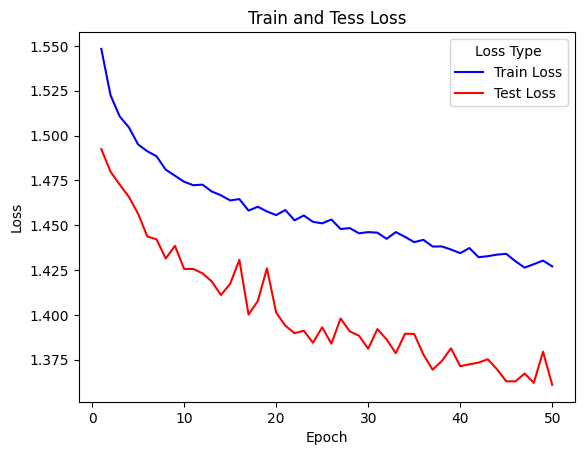

In [16]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Loss': train_loss_list,
    'Test Loss': test_loss_list
})

# Melt the DataFrame to long format for seaborn
data_long = data.melt('Epoch', var_name='Loss Type', value_name='Loss')

# Plot using seaborn
sns.lineplot(x='Epoch', y='Loss', hue='Loss Type',  palette=['b', 'r'], data=data_long)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Tess Loss')

# Show the plot
plt.legend(title='Loss Type')
plt.show()

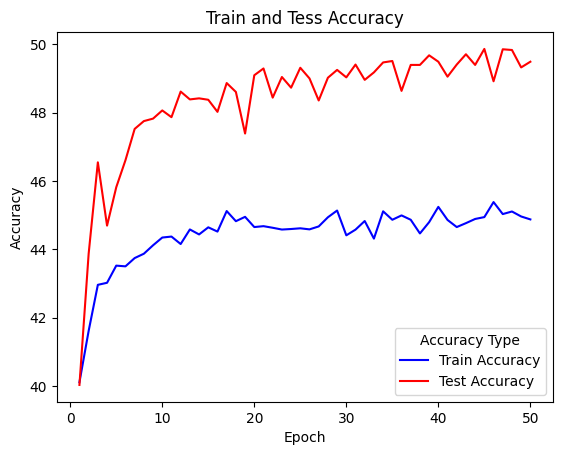

In [17]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Accuracy': train_acc_list,
    'Test Accuracy': test_acc_list
})

# Melt the DataFrame to long format for seaborn
data_long = data.melt('Epoch', var_name='Accuracy Type', value_name='Accuracy')

# Plot using seaborn
sns.lineplot(x='Epoch', y='Accuracy', hue='Accuracy Type',  palette=['b', 'r'], data=data_long)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Tess Accuracy')

# Show the plot
plt.legend(title='Accuracy Type')
plt.show()

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2269833310.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df, palette='muted')


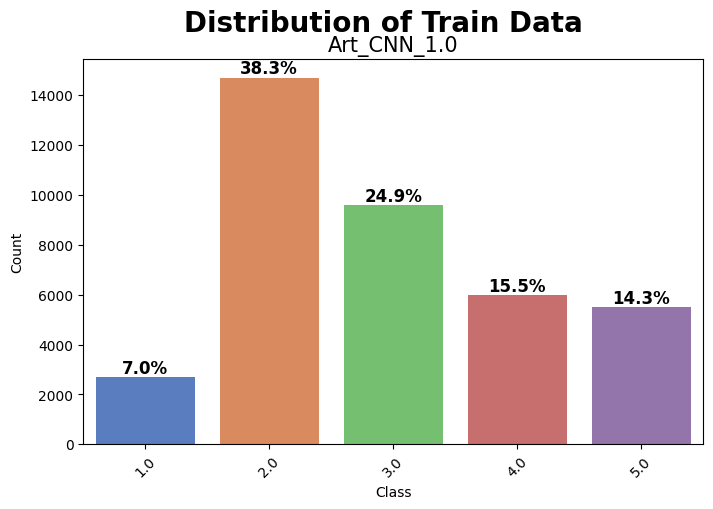

In [18]:
class_counts = {class_name: 0 for class_name in dataset.classes}

for idx in trainset_simple.indices:  # Access indices from trainset_simple
    label = dataset.targets[idx]  # Get label using the index
    class_counts[dataset.classes[label]] += 1

total_train_samples = sum(class_counts.values())

# Convert class_counts dictionary to DataFrame (keep count values)
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Plot training distribution with count on y-axis
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df, palette='muted')

# Annotate bars with percentage values
for p in ax.patches:
    percentage = (p.get_height() / total_train_samples) * 100  # Convert count to percentage
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Customize plot
plt.suptitle("Distribution of Train Data", fontsize=20, fontweight='bold')
plt.title("Art_CNN_1.0", fontsize=15)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\3310846455.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="muted")


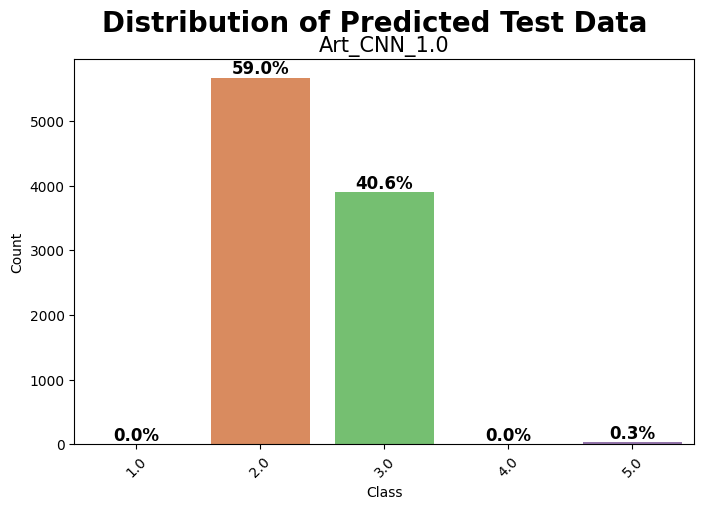

In [19]:
predicted_counts = {class_name: 0 for class_name in dataset.classes}

for pred in all_preds:
    predicted_counts[dataset.classes[pred]] += 1

total_preds = sum(predicted_counts.values())

# Convert predicted_counts dictionary to DataFrame (keep count values)
df_preds = pd.DataFrame(list(predicted_counts.items()), columns=['Class', 'Count'])

# Plot predicted class distribution with count on y-axis
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="muted")

# Annotate bars with percentage values
for p in ax.patches:
    percentage = (p.get_height() / total_preds) * 100  # Convert count to percentage
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Customize plot
plt.suptitle("Distribution of Predicted Test Data", fontsize=20, fontweight='bold')
plt.title("Art_CNN_1.0", fontsize=15)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [20]:
def class_pred_hist(label):
    true_labels = [testset_simple[i][1] for i in range(len(testset_simple))]

    class_indices = [i for i, true_label in enumerate(true_labels) if true_label == label]

    # Step 2: Track predictions for Class 1 data points
    class_predictions = [all_preds[i] for i in class_indices]

    # Step 3: Count how many times each class was predicted for Class 1 data points
    predicted_counts_class = {class_name: 0 for class_name in dataset.classes}
    for pred in class_predictions:
        predicted_counts_class[dataset.classes[pred]] += 1

    # Convert the dictionary to a DataFrame
    df_class_preds = pd.DataFrame(list(predicted_counts_class.items()), columns=['Class', 'Count'])

    # Step 4: Plot the results
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")

    # Annotate bars with count values
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    # Customize plot
    plt.suptitle("Predictions for Data Points in Class "+str(label+1), fontsize=20, fontweight='bold')
    plt.title("Art_CNN_1.0", fontsize=15)
    plt.xticks(rotation=45)
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.show()

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


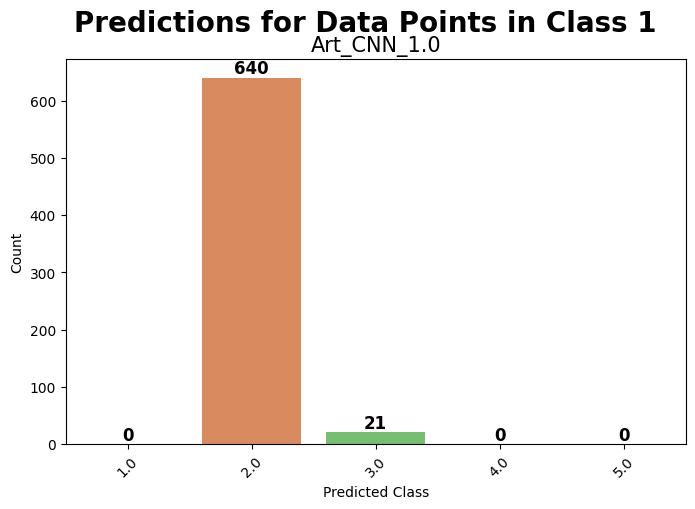

In [21]:
class_pred_hist(0)

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


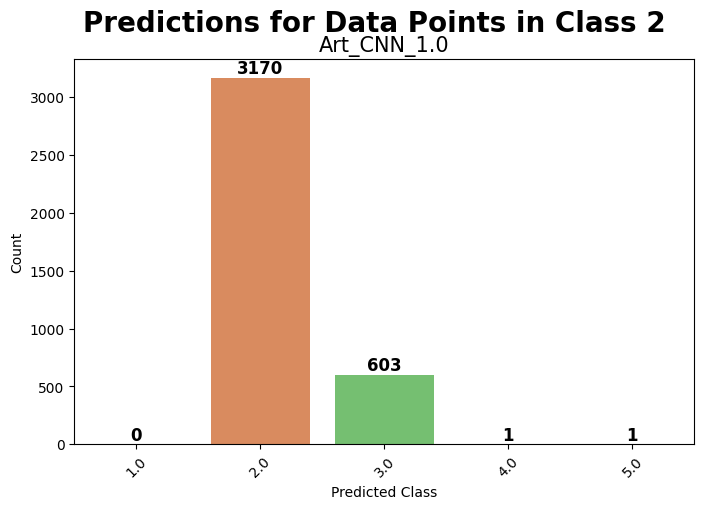

In [22]:
class_pred_hist(1)

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


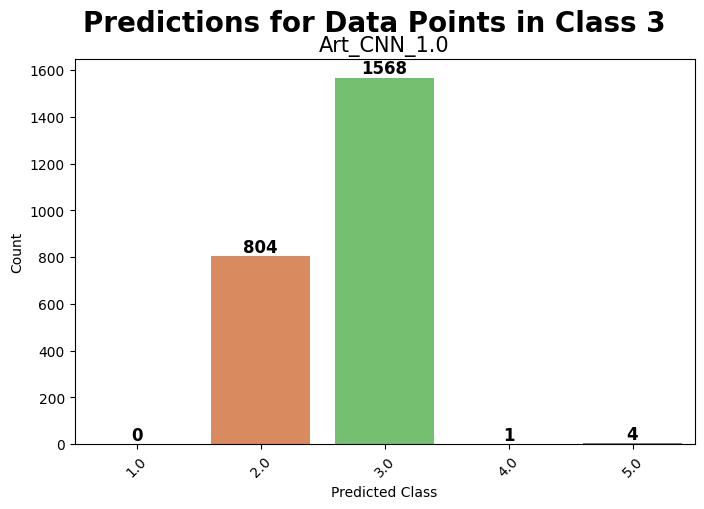

In [23]:
class_pred_hist(2)

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


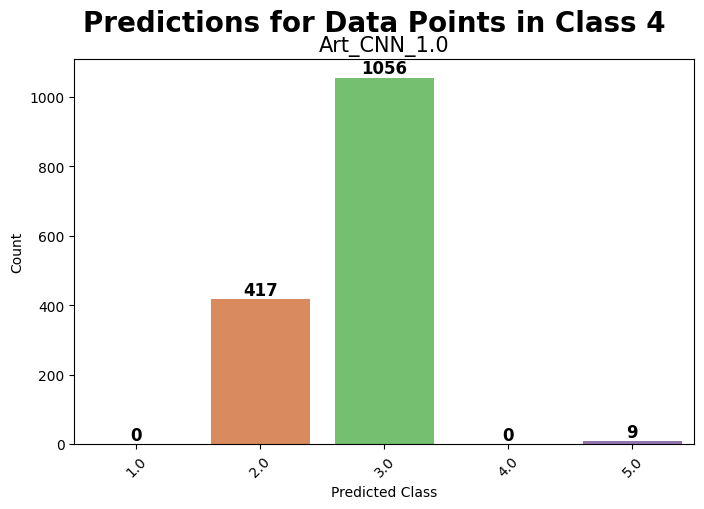

In [24]:
class_pred_hist(3)

C:\Users\Jona\AppData\Local\Temp\ipykernel_15816\2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


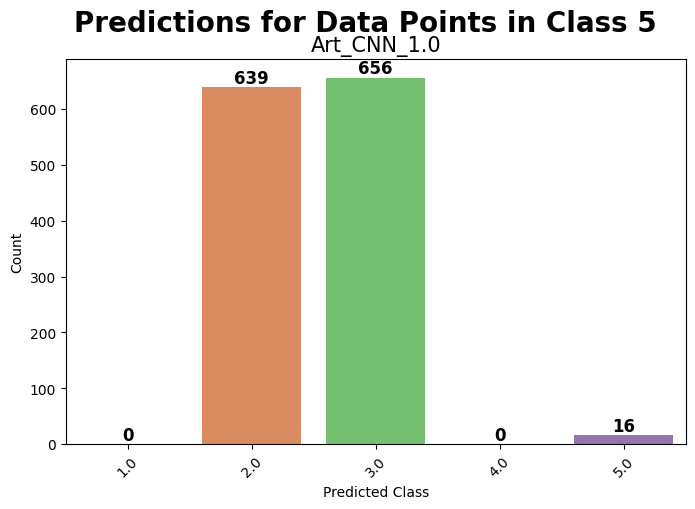

In [25]:
class_pred_hist(4)

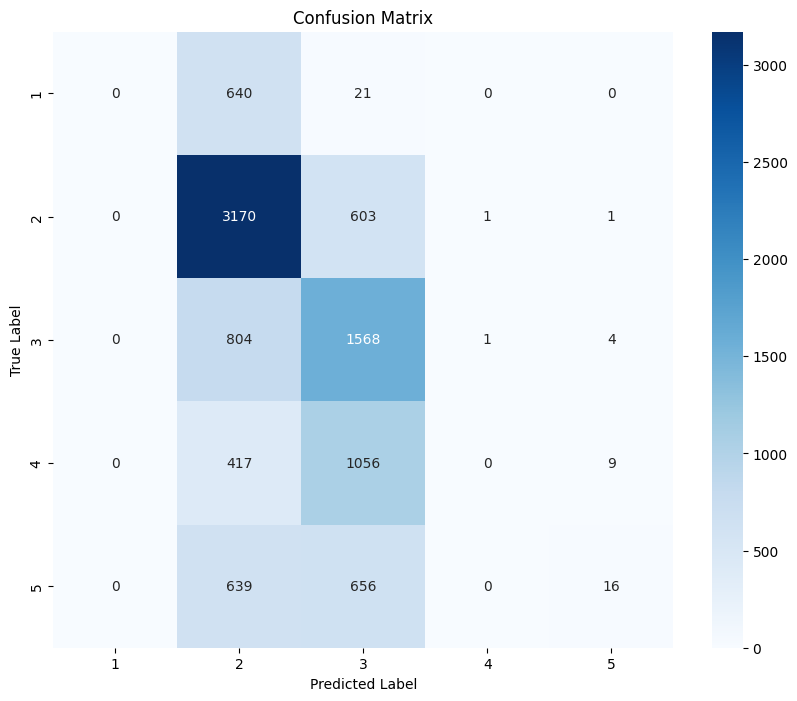

In [26]:
cm = confusion_matrix(all_true, all_preds)

# Adjust class labels to start from 1 instead of 0
class_labels = [str(i+1) for i in range(len(cm))]  # Assuming class indices are 0-based

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [27]:
def log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0):
    """
    Logs embeddings to TensorBoard.

    Parameters:
      writer (SummaryWriter): TensorBoard writer.
      embeddings_dict (dict): A dictionary where keys are model names (str)
                              and values are embeddings (torch.Tensor of shape [N, D]).
      metadata_dict (dict): A dictionary where keys are model names (str)
                            and values are lists of metadata strings for each sample.
      global_step (int): Global training step (for TensorBoard).
    """
    for name, emb in embeddings_dict.items():
        # .add_embedding expects a 2D tensor and an optional metadata list
        writer.add_embedding(emb, metadata=metadata_dict.get(name, None),
                             tag=name, global_step=global_step)
    print("Embeddings logged to TensorBoard.")


In [28]:
# %% Cell 12: Prepare embeddings from custom, pre‑trained (frozen), and fine‑tuned models and log them
#
# For speed we use only the first 500 test samples from each model.
# Note: Since the models use different input transformations,
# the embeddings come from different networks.
#
# We prepare metadata (the true label for each sample) as a list of strings.
# Then, we log these embeddings using TensorBoard.
num_samples = 500

# For the custom model (simple CNN), we already have embeddings and labels (from Cell 4)
embeddings_custom_np = embeddings_custom.cpu()  # shape: [num_samples, embedding_dim]
metadata_custom = [str(label.item()) for label in labels_custom]

# Create a dictionary of embeddings and metadata
embeddings_dict = {
    "custom": embeddings_custom_np,
}
metadata_dict = {
    "custom": metadata_custom,
}

# Create a TensorBoard SummaryWriter (logs will be saved in the 'runs/embeddings' directory)
log_dir = r"C:\Users\Jona\Desktop\DataScience\DS4440\Midterm\runs\embeddings_3"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)

# Log the embeddings (global_step can be set to any value; here we use 0)
log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0)
writer.close()

print("\nTo visualize the embeddings, run in a terminal:\n\n tensorboard --logdir=runs/embeddings\n")


Embeddings logged to TensorBoard.

To visualize the embeddings, run in a terminal:

 tensorboard --logdir=runs/embeddings

